In [1]:
# Analyse pipeline data

In [108]:
from pylab import *
import matplotlib as mpl
import seaborn as sns
sys.path.append('/Users/ban115/bolton/craft/code/python') # for calc11

import calc11
import os

import numpy as np
from scipy import constants
import fdmt # you'll need to have ../python in  you PYTHONPATH.
import craco
reload(fdmt)
%matplotlib inline
def myimshow(d, **kwargs):
    imshow(d, aspect='auto', origin='lower', interpolation='nearest', **kwargs)
    
def plot_prep_fdmt(iuv, prepout, fdmtout):
    fig, axs = subplots(1,2)
    axs[0].imshow(prepout[iuv,:,:].real.T, aspect='auto', origin='lower', interpolation='nearest')
    axs[1].imshow(fdmtout[iuv,:,:].real.T, aspect='auto', origin='lower', interpolation='nearest')
    print 'prepout iuv=', iuv, craco.printstats(prepout[iuv,:,:].real)
    print 'fdmtout iuv=', iuv, craco.printstats(fdmtout[iuv,:,:].real)

    axs[0].set_xlabel('T')
    axs[0].set_ylabel('Channel')
    axs[1].set_xlabel('T')
    axs[1].set_ylabel('IDM')

    
def complex2time(d):
    assert np.iscomplexobj(d)
    #(16, 8, 256, 256)
    nd, nt, npix, _ = d.shape
    dout = np.empty((nd, nt*2, npix, npix), dtype=np.float32)
    dout[:,::2,:,:] = d.real
    dout[:,1::2,:,:] = d.imag
    return dout

def mergeuv(d):
    (nuv, nt, nd, nuvwide) = d.shape
    return d.transpose((0,3,1,2)).reshape(-1, nt, nd)
    

FDMTOUT shape (8192, 16, 32)
prepout iuv= 0  max/min/mean/rms/sum/S/N = 1.00e+00/0.00e+00/6.25e-02/2.42e-01/3.20e+01/4.1 peak at (1, 8)
fdmtout iuv= 0  max/min/mean/rms/sum/S/N = 1.25e-01/0.00e+00/6.33e-03/1.03e-02/3.24e+00/12.2 peak at (2, 1)
prepout iuv= 1  max/min/mean/rms/sum/S/N = 1.00e+00/0.00e+00/6.25e-02/2.42e-01/3.20e+01/4.1 peak at (1, 8)
fdmtout iuv= 1  max/min/mean/rms/sum/S/N = 1.25e-01/0.00e+00/6.33e-03/1.03e-02/3.24e+00/12.2 peak at (2, 1)
prepout iuv= 2  max/min/mean/rms/sum/S/N = 1.00e+00/0.00e+00/6.25e-02/2.42e-01/3.20e+01/4.1 peak at (1, 8)
fdmtout iuv= 2  max/min/mean/rms/sum/S/N = 1.25e-01/0.00e+00/6.33e-03/1.03e-02/3.24e+00/12.2 peak at (2, 1)


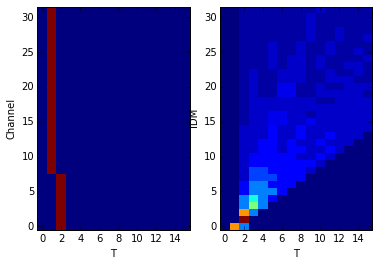

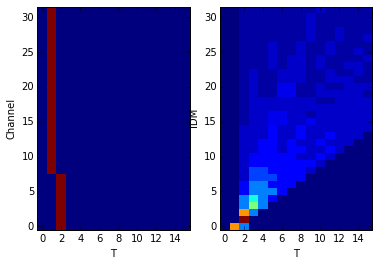

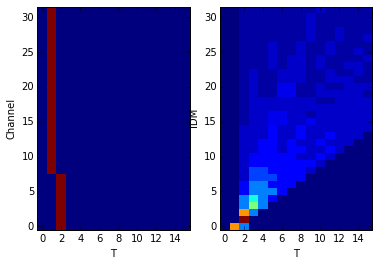

In [109]:

thedir='/Users/ban115/bolton/craft/code/python/cracotest/ant3/frb_d2_t0_a1_sninf_lm00'
fdmtout = np.load(os.path.join(thedir, 'blk_0_fdmt.npy'))
prepout = np.load(os.path.join(thedir, 'blk_0_prepare.npy'))

imgout = complex2time(np.load(os.path.join(thedir, 'blk_0_img.npy')))
din = np.load(os.path.join(thedir, 'blk_0_input.npy'))
(max_idm, max_time, max_ypix, max_xpix) = np.unravel_index(imgout.argmax(), imgout.shape)


idm =  0
t = 0

fdmtout = mergeuv(fdmtout)
prepout = mergeuv(prepout)

print 'FDMTOUT shape', fdmtout.shape

plot_prep_fdmt(0, prepout, fdmtout)
plot_prep_fdmt(1, prepout, fdmtout)
plot_prep_fdmt(2, prepout, fdmtout)

Total of max values per UV for real part 3.0


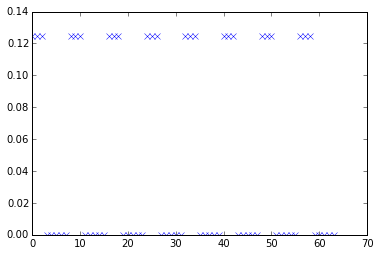

In [110]:
plot(fdmtout.real.max(axis=1).max(axis=1)[:64], 'x')
print 'Total of max values per UV for real part', fdmtout.real.max(axis=1).max(axis=1).sum()

Total in FDMT at idm= 0 t= 0 (1.3125+0j)


(0, 15)

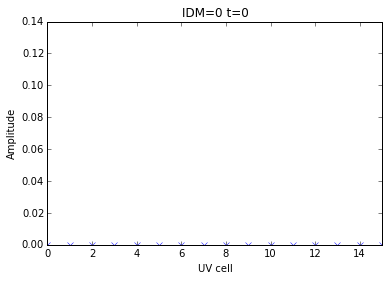

In [111]:

plot(fdmtout[:,t,idm],'x')
xlabel('UV cell')
ylabel('Amplitude')
title('IDM={} t={}'.format(idm, t))
print 'Total in FDMT at idm=', idm, 't=', t, fdmtout[:,t,idm].sum()
xlim(0,15)

In [112]:
imgout.shape

(16, 16, 256, 256)

In [113]:
din.shape


(3, 256, 16)

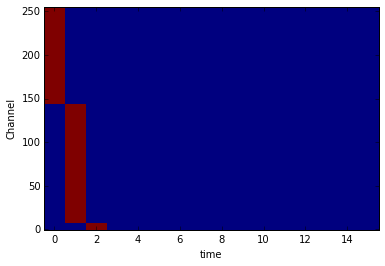

In [114]:
myimshow(din[0, :, :].real)
xlabel('time')
ylabel('Channel')

In [115]:
np.all(din - din[0,:,:] == 0) # all baselines have same data


True

 max/min/mean/rms/sum/S/N = 7.81e+00/-3.91e+00/-3.35e-10/5.27e-01/-5.62e-03/14.8 peak at (1, 1, 0, 128)
('Best pixel', ' max/min/mean/rms/sum/S/N = 7.81e+00/0.00e+00/6.25e-01/1.13e+00/1.60e+02/6.9 peak at (1, 1)')


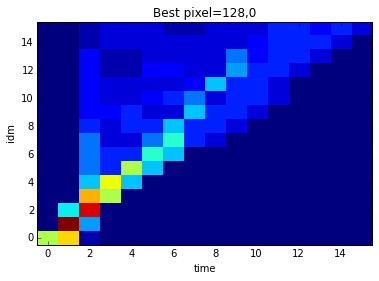

In [116]:
myimshow(imgout[:,:,max_ypix,max_xpix])
print(craco.printstats(imgout))
print('Best pixel', craco.printstats(imgout[:,:,max_ypix,max_xpix]))
title("Best pixel=%s,%s" % (max_xpix, max_ypix) )
xlabel('time')
ylabel('idm')
      

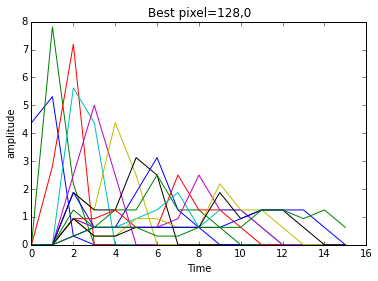

In [117]:
plot(imgout[:,:,max_ypix,max_xpix].T)
title("Best pixel=%s,%s" % (max_xpix, max_ypix) )
ylabel('amplitude')
xlabel('Time')

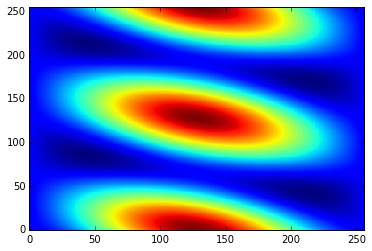

In [118]:
myimshow(imgout[max_idm,max_time, :, :])

In [87]:
import craco_kernels
import boxcar
class Plan(object):
    def __init__(self):
        self.threshold = 10
        self.nd = 4
        self.npix = 256
        self.nbox = 4
        self.boxcar_weight = 'sqrt'
    
bc = craco_kernels.Boxcar(None, Plan(), None)
grouper = craco_kernels.Grouper(None, Plan(), None)
boxout = bc(0, imgout[0,0,:,:])
grouper(0, 0, bcout)

NameError: name 'bcout' is not defined

In [88]:
bcout.shape
craco.printstats(boxout)

NameError: name 'bcout' is not defined

0

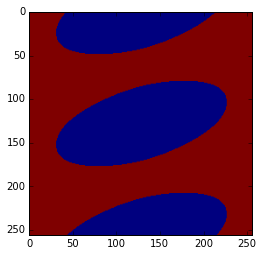

In [89]:
max_box = np.argmax(boxout, axis=2)
i,j = np.indices(max_box.shape)
threshold = 10.0
imshow(max_box)
max_box[128,128]

In [90]:
pys, pxs = np.where(boxout[i,j,max_box] >= threshold)
boxout[128,128,:]

array([4.375    , 3.0935922, 2.5259073, 2.1875   ], dtype=float32)